In [2]:
pink = (129,0,255)

## MediaPipe implementation
References:
- https://medium.com/augmented-startups/face-detection-in-5-minutes-70-fps-on-cpu-690efd10bbae

In [3]:
import cv2
import mediapipe as mp
import time

def mpDetect(image):
    mp_face_detection = mp.solutions.face_detection
    mp_drawing = mp.solutions.drawing_utils

    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.50)
    results = face_detection.process(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if results.detections:
      for detection in results.detections:
        bBox = detection.location_data.relative_bounding_box
        h, w, c = image.shape
        boundBox = int(bBox.xmin * w), int(bBox.ymin * h), int(bBox.width * w), int(bBox.height * h)
        #print(boundBox)
        
        font = cv2.FONT_HERSHEY_SIMPLEX; fontScale = 0.5; thickness = 2; lineType = 2
        conf = detection.score[0]
        cv2.putText(image, f"conf: {conf}", (boundBox[0], boundBox[1] - 10), font, fontScale, (255,0,0), thickness, lineType)
        #cv2.rectangle(image, (int(bBox.xmin), int(bBox.ymin)), (int(boundBox[0]*-1), int(boundBox[1]*-1)), pink, 2)
        mp_drawing.draw_detection(image, detection)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image
    #return (image, conf)

## Caffe implementation
References:
- Dude, just trust me
- Dabide 

In [4]:
import numpy as np
import time
import cv2

def caffeDetect(image):
    prototxt = "./deploy.prototxt.txt"
    model = "./res10_300x300_ssd_iter_140000.caffemodel"
    net = cv2.dnn.readNetFromCaffe(prototxt, model)

    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300,300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    for i in range(0, detections.shape[2]):
        #get confidence here
        thresh = 0.5
        confidence = detections[0, 0 , i, 2]
        if confidence < thresh:
            continue
        
        #box that tracks face
        box  = detections[0,0,i,3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        #draw box
        text = "conf: {:2f}".format(confidence)
       
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.rectangle(image, (startX, startY), (endX, endY), pink, 2)
        cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,0,255), 2)

    return image
    #return (image, conf)

## Multi-Task Convolutional Neural Network model
References:
- https://www.youtube.com/watch?v=8OPkRNE3h-o
- https://towardsdatascience.com/cnn-based-face-detector-from-dlib-c3696195e01c

In [5]:
import cv2
import mtcnn

def mtcnnDetect(image):
    
    face_detector = mtcnn.MTCNN()

    # Detect the faces
    results = face_detector.detect_faces(image)

    # Draw detected boxes on the image.
    for res in results:
        x1, y1, width, height = res['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        
        conf_t = 0.99
        confidence = res['confidence']
        #if confidence < conf_t:
        #    continue
        key_points = res['keypoints'].values()

        cv2.rectangle(image, (x1, y1), (x2, y2), pink, thickness=2)
        cv2.putText(image, f'conf: {confidence:.3f}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

        for point in key_points:
            cv2.circle(image, point, 5, (255, 0, 0), thickness=-1)

    return image
    #eturn (image, confidence)


## Haar Cascade model
References: 
* https://towardsdatascience.com/simple-face-detection-in-python-1fcda0ea648e
* https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
* https://techtutorialsx.com/2019/04/21/python-opencv-flipping-an-image/
* https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml

In [6]:
import cv2
import numpy as np

#output_conf = 0

def haarDetect(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale 
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale3(gray, 1.1, 4, outputRejectLevels=True) # Detect faces
    #print(faces)

    for i in range(len(faces[0])):
        rect, count, conf = faces[0][i], faces[1][i], faces[2][i]
        output_conf = conf
        
        (x, y, w, h) = rect
        cv2.rectangle(image, (x, y), (x+w, y+h), pink, 2) # Draw rectangle around the faces
        font = cv2.FONT_HERSHEY_SIMPLEX; fontScale = 0.5; thickness = 2; lineType = 2
        cv2.putText(image, f"conf: {conf}", (x, y-10), font, fontScale, (0,0,255), thickness, lineType)
        
    return image
    #return (image, output_conf)

## Video Capture
This function serves as the input stream for the models, allowing for live input.

References: 
* https://www.geeksforgeeks.org/python-opencv-capture-video-from-camera/
* https://docs.opencv.org/4.x/dd/d43/tutorial_py_video_display.html

In [7]:
import matplotlib.pyplot as plt
from time import time, sleep

# Captiure a frame from video feed
def videoCapture(model, filename="./"):
    # define a video capture object
    vid = cv2.VideoCapture(0)
    start = time()
    curr = abs(int(start-time()))

    while(True):
        # Capture the video frame by frame
        ret, frame = vid.read()
        frame = cv2.flip(frame, 1)
        start1 = time()
        models = {
                "Haar": haarDetect,
                "Media Pipe": mpDetect, 
                "Caffe": caffeDetect, 
                "MTCNN": mtcnnDetect,
                "none": lambda frame: (frame, 0)}
        output = models[model](frame)
        frame = output
        end1 = time()
        curr1 = end1- start1
        
        # Capture from video feed after specified time
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print(f"Model: {model}", f"\nPerformance: {curr1} seconds")
            plt.imshow(frame[...,::-1]) 
            break

        # Put text
        font = cv2.FONT_HERSHEY_SIMPLEX; fontScale = 0.4; fontColor = pink; thickness = 2; lineType = 1
        curr = int(time()-start)

        # Put information in frame
        cv2.putText(frame , f"Elapsed: {curr} seconds", (10, 50), font, fontScale, fontColor, thickness, lineType)
        cv2.putText(frame , f"Model: {model}", (10, 70), font, fontScale, fontColor, thickness, lineType)
        cv2.putText(frame, f"Performance: {curr1} seconds", (10, 90), font, fontScale, fontColor, thickness, lineType)
        #cv2.putText(frame, f"Average Confidence: {confidence}", (10, 90+20), font, fontScale, fontColor, thickness, lineType)
        #cv2.putText(frame, f"Frames: {counter}", (10, 90+40), font, fontScale, fontColor, thickness, lineType)
        
        # Display the resulting frame
        cv2.imshow(f'Video Input (press Q to snap)', frame)
        
    # After the loop release the cap object
    vid.release()
    # Destroy all the windowsq
    cv2.destroyAllWindows()

## Testing (18-20 inches of distance)

Model: Haar 
Performance: 0.15600228309631348 seconds
Model: Haar 
Performance: 0.15099668502807617 seconds
Model: Haar 
Performance: 0.1759958267211914 seconds
Model: Haar 
Performance: 0.1569972038269043 seconds


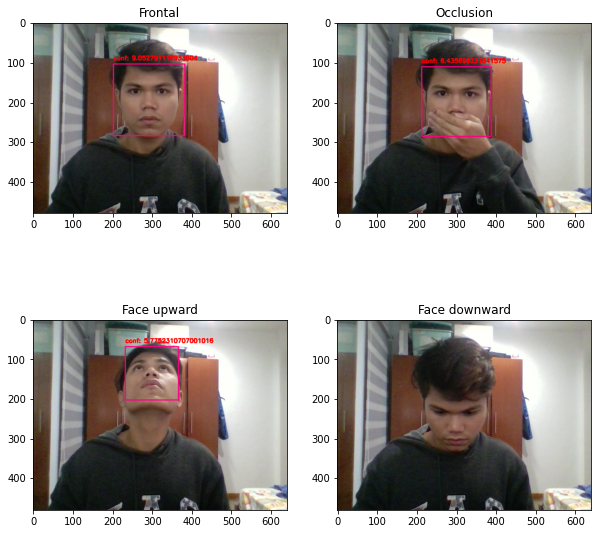

In [10]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Frontal")
videoCapture("Haar")

plt.subplot(2,2,2)
plt.title("Occlusion")
videoCapture("Haar")

plt.subplot(2,2,3)
plt.title("Face upward")
videoCapture("Haar")

plt.subplot(2,2,4)
plt.title("Face downward")
videoCapture("Haar")

Model: MTCNN 
Performance: 3.3539977073669434 seconds
Model: MTCNN 
Performance: 3.043678045272827 seconds
Model: MTCNN 
Performance: 3.152008533477783 seconds
Model: MTCNN 
Performance: 3.1720428466796875 seconds


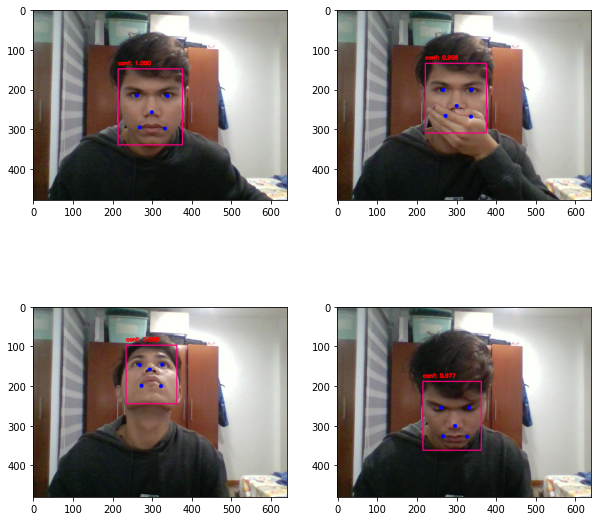

In [11]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
videoCapture("MTCNN")

plt.subplot(2,2,2)
videoCapture("MTCNN")

plt.subplot(2,2,3)
videoCapture("MTCNN")

plt.subplot(2,2,4)
videoCapture("MTCNN")

Model: Media Pipe 
Performance: 0.023005962371826172 seconds
Model: Media Pipe 
Performance: 0.05299949645996094 seconds
Model: Media Pipe 
Performance: 0.05000042915344238 seconds
Model: Media Pipe 
Performance: 0.05500674247741699 seconds


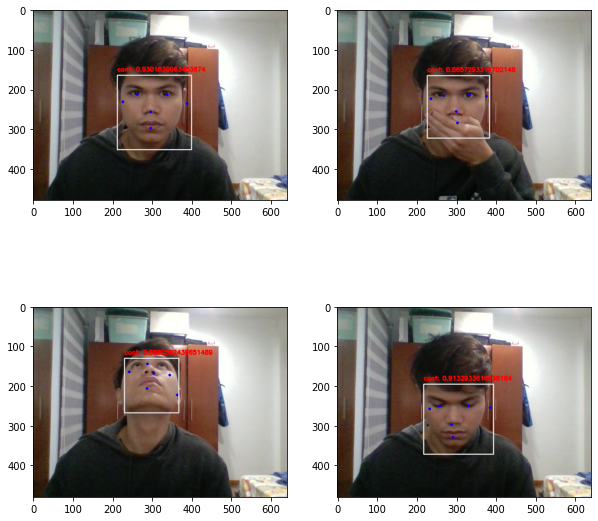

In [12]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
videoCapture("Media Pipe")

plt.subplot(2,2,2)
videoCapture("Media Pipe")

plt.subplot(2,2,3)
videoCapture("Media Pipe")

plt.subplot(2,2,4)
videoCapture("Media Pipe")

Model: Caffe 
Performance: 0.12399864196777344 seconds
Model: Caffe 
Performance: 0.11600065231323242 seconds
Model: Caffe 
Performance: 0.13199591636657715 seconds
Model: Caffe 
Performance: 0.1360020637512207 seconds


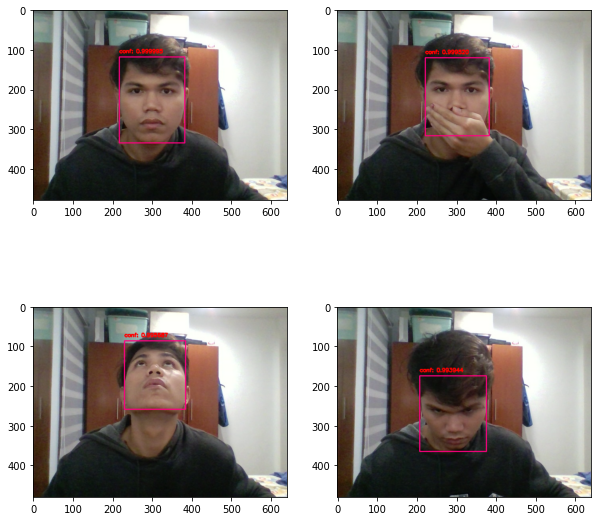

In [13]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
videoCapture("Caffe")

plt.subplot(2,2,2)
videoCapture("Caffe")

plt.subplot(2,2,3)
videoCapture("Caffe")

plt.subplot(2,2,4)
videoCapture("Caffe")

### Tabulation of Results
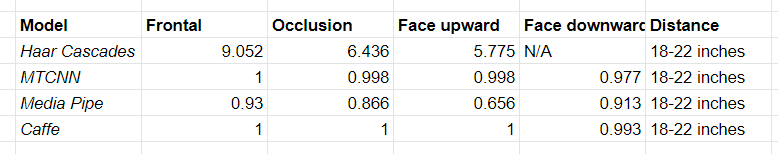

### Setup and Limitations
I tested 4 models, namely, Haar Cascades, Multi-Task Convolutional Neural Network (MTCNN), Media Pipe's model, and a Caffe model.  I was not able to document faces in varying distances, although it's important to note that a distance of more than a meter would make it significantly harder for the models to detect faces, however, Media Pipe and Caffe model notably did not encounter any issues during testing. I also made changes with the Haar Cascades model as I deviated from the Inception V3 classifier prescribed in the module because of performance issues, with the deviations making it possible for me to run the Haar model at all. This is also the main reason why I used the Media Pipe and Caffe models as they perform faster than most of the models I tested.
### Observations
The Haar Cascades model performed the least among all the other models as it can only detect front-facing faces, with small margins for detecting side-facing faces or downwards-facing faces. MTCNN was rather difficult to test as it was significantly slower than the rest of the models used, but nonetheless it was accurate and was able to detect faces in all 4 testing angles. The same applies for both Media Pipe and the Caffe model, with the Caffe model relatively being the best in terms of accuracy and speed. 
### Recommendations
I was late in submitting my face detection program due to me having to constantly debug code on top of having to find models and methods that would perform better with my PC as using the Haar model with Inception V3 in the module would crash the program. I recommend testing these models with the prescribed Inception V3 classifier from the module with better equipment and setup. I would also recommend testing these models with varying distances along with multiple angles and subjects, and record any notable performance metrics such as speed, prediction accuracy/confidence, and actual accuracy relative to expected results.

Model: Haar 
Performance: 0.29498720169067383 seconds


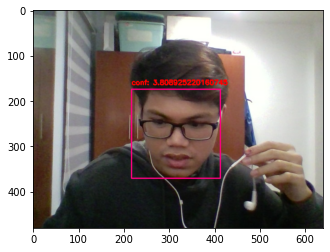

In [15]:
videoCapture("Haar")

Model: MTCNN 
Performance: 12.044228076934814 seconds


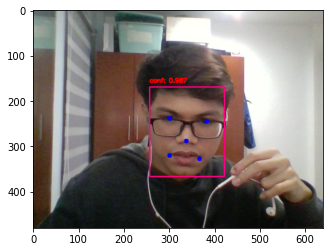

In [16]:
videoCapture("MTCNN")

Model: Media Pipe 
Performance: 0.12656474113464355 seconds


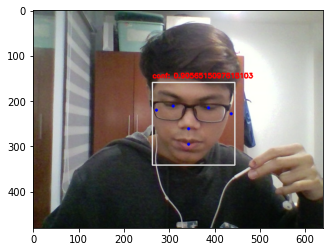

In [17]:
videoCapture("Media Pipe")

Model: Caffe 
Performance: 0.39609217643737793 seconds


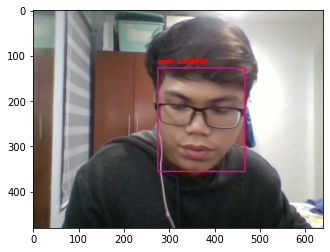

In [18]:
videoCapture("Caffe")